# waypoints

## define agents

In [1]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [2]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"../maps/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='Oschersleben1')

## create waypoints

In [10]:

done = False
env = WPEnv(map_name='race2', begin_pos=[0.0702245, 0.3002981, 2.79787])
obs = env.reset()
agent = FGAgent(speed=3.0, bubble_r=0.5)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [11]:
with open('../maps/race2-wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [9]:
import numpy as np

with open('../maps/phy6-wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[32][:2])
print(dist)
print(len(wps))
print(len(wps)//70)

0.40318595272794694
2698
38


In [8]:
from tqdm import tqdm
import gym

map_name = 'race1'
env = gym.make('f110_gym:f110-v0', map=f"../maps/{map_name}", map_ext='.png', num_agents=1)
cnt = 0
for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.4:
        cnt += 1
print(cnt)

100%|██████████| 8658/8658 [00:03<00:00, 2251.99it/s]

43


In [27]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

12948

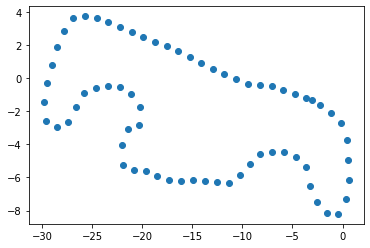

In [10]:
import matplotlib.pyplot as plt
wps =wps[::40]
plt.scatter(wps[:,0], wps[:, 1])

# environment

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=7.0,
                 n_cps = 70,
                 cp_reward = 0.2,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='phy',
                 padding_punish=-0.05,
                 safe_padding=0.4,
                 laps = 1.0,
                 min_deg=80,
                 max_deg=280,
                 begin_pos=[-3.0702245, -2.3002981, 2.79787]
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(202,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [1.0] * 100
        self.padding_punish = padding_punish
        
        self.total_padding_punish = 0
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.begin_pos = begin_pos
        self.ang_vel_diff_hist = [0.0]*50
        self.prev_ang_vel = 0.0
        self.oscilation_cum_rew = 0
        self.prev_cp_t = 0
        
        self.cp_prev_vel = []
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

    def load_train_setup(self):
        no = np.random.choice([1,2,3,4,5,6])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/{self.train_map_name}{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/{self.train_map_name}1-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.oscilation_cum_rew = 0
        self.prev_vel = [1.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        self.cp_prev_vel = [0.0,]
        self.ang_vel_diff_hist = [0.0,]
        self.prev_ang_vel = 0.0
        self.prev_cp_t = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            rotate = np.random.choice([0, np.pi])
            if rotate != 0:
                self.checkpoints = self.checkpoints[::-1]
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            start_point[-1] += rotate
            
        else:
            dists = cdist([self.begin_pos[:2]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = self.begin_pos
            
        self.next_cp_idx = (start_idx + 4)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        ## TAKES CARE OF CHECKPOINTS THAT FALL OVER OBSTACLES
        if done:
            return self.reset()
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        ranges = obs['scans'][0]
        ranges = ranges[int((self.min_deg/360)*len(ranges)):int((self.max_deg/360)*len(ranges))]
        scanner = np.clip(ranges, 0, self.scan_range)
        
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
        if self.test_map_name is None:
            noise = np.random.normal(loc=0.0, scale=0.1, size=state.shape)
            state = state + noise
        
        return state
    
    def checkpoint(self, position, t):
        return_cp_idx = (self.next_cp_idx - 14)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
#             time_diff = t - self.prev_cp_t
#             reward = max(self.cp_reward + (0.4 - time_diff)*0.5, self.cp_reward)
            reward = self.cp_reward
            self.prev_cp_t = t
#            print(time_diff)
#             reward = self.cp_reward
#            reward += (np.mean(self.cp_prev_vel)/self.max_v)
#             reward -= np.mean(self.ang_vel_diff_hist)/(np.pi/3)
#            reward *= self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
            self.ang_vel_diff_hist = [0,]
            self.cp_prev_vel = [0,]
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        act_v += np.random.normal(0, 1.0)
        
        #th = action[1]*np.pi/6
        #for real car
        th = action[1]*0.34
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

#         ang_vel_diff = abs(th - self.prev_ang_vel)
#         self.prev_ang_vel = th
#         self.ang_vel_diff_hist.append(ang_vel_diff)
        
#        self.cp_prev_vel.append(act_v)
    
        finish_time = 100
        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            #if self.test_map_name is not None:
            #print('CRASHED')
            return next_state, reward, done, {'finish_time': finish_time}
            
        cp_reward = self.checkpoint(position, obs['lap_times'][0])
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
#           reward = np.exp(2.5 - 0.05*t)
            finish_time = t
#             fairlap = 35
#             reward = max(0.5*(fairlap - t), 0)
            #reward = self.cp_reward
            #print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.mean(self.prev_vel)<1.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += self.padding_punish
            self.total_padding_punish += self.padding_punish
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position, 'finish_time': finish_time,
                                          'oscilation': self.oscilation_cum_rew, 'padding': self.total_padding_punish}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset().shape

(202,)

# training

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [ ]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 12,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
    'num_envs_per_worker': 3,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0001,
#     'horizon': 8000
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
#print("FINE TUNING")
trainer.restore('../checkpoints/phy_v6.0.3/checkpoint_000226/checkpoint-226')

print(trainer.config)
rewards = []
eval_rewards = []
best_time = 1000
models_path = '../checkpoints'
best_reward = -100

import pickle

def evaluate(model, envs):
    avg_r = []
    
    for env in envs:
        done = False
        obs = env.reset()

        r = 0
        while not done:
            action = model.compute_single_action(obs, explore=False)
            obs, reward, done, info = env.step(action)
            r += reward

        avg_r.append(r)
        
    return np.mean(avg_r)


eval_envs = [
    F110RaceEnv({}, test_map_name='phy1', laps=1),
    F110RaceEnv({}, test_map_name='phy2', laps=1),
    F110RaceEnv({}, test_map_name='phy3', laps=1),
    F110RaceEnv({}, test_map_name='phy4', laps=1),
    F110RaceEnv({}, test_map_name='phy5', laps=1),
    F110RaceEnv({}, test_map_name='phy6', laps=1),
]


sim_name = 'phy_v6.1.1'

for i in range(500):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/{sim_name}_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0:
        eval_reward = evaluate(trainer, envs=eval_envs)
        eval_rewards.append(eval_reward)
        with open(f'{models_path}/{sim_name}_er', 'wb') as f:
            pickle.dump(eval_rewards, f)
        if eval_reward > best_reward:
            best_reward = eval_reward
            cp = trainer.save(f"{models_path}/{sim_name}")
            print("checkpoint saved at", cp)


2022-05-23 09:21:31,093	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=12 num_envs_per_worker=3 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 2777.
2022-05-23 09:21:31,094	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-23 09:21:31,094	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=40123) 2022-05-23 09:21:36,757	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=40116) 2022-05-23 09:21:36,746	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVecto

{'num_workers': 12, 'num_envs_per_worker': 3, 'create_env_on_driver': False, 'rollout_fragment_length': 2777, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0001, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_

(RolloutWorker pid=40103) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40102) agent on ../maps/phy4 got reward 0.2 in 2.1299999999999986. RETURNED
(RolloutWorker pid=40103) agent on ../maps/phy2 got reward 3.600000000000001 in 6.259999999999911. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy5 got reward 5.600000000000002 in 7.8299999999998775. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy2 got reward 6.400000000000003 in 8.969999999999853. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy4 got reward 4.200000000000001 in 8.039999999999873. STOPPED
(RolloutWorker pid=40115) agent on ../maps/phy3 got reward 7.000000000000004 in 9.189999999999849. STOPPED
(RolloutWorker pid=40114) agent on ../maps/phy3 got reward 8.000000000000004 in 10.49999999999982. RETURNED
(RolloutWorker pid=40112) agent on ../maps/phy4 got reward 7.600000000000004 in 11.689999999999795. RETURNED
(RolloutWorker pid=40108) agent on ../maps/phy2 got reward 8.8 in 11.63

2022-05-23 09:23:03,538	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


lap: [14.44]
checkpoint saved at ../checkpoints/phy_v6.1.1/checkpoint_000227/checkpoint-227
(RolloutWorker pid=40121) agent on ../maps/phy1 got reward 1.0 in 3.7199999999999647. RETURNED
(RolloutWorker pid=40117) agent on ../maps/phy2 got reward 9.599999999999998 in 11.409999999999801. RETURNED
(RolloutWorker pid=40112) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40103) agent on ../maps/phy5 got reward 0.4 in 2.579999999999989. STOPPED
(RolloutWorker pid=40119) agent on ../maps/phy1 got reward 9.199999999999935 in 16.259999999999742. RETURNED
(RolloutWorker pid=40109) agent on ../maps/phy1 got reward 11.59999999999999 in 13.33999999999976. RETURNED
(RolloutWorker pid=40114) agent on ../maps/phy1 got reward 9.0 in 10.739999999999815. RETURNED
(RolloutWorker pid=40123) agent on ../maps/phy2 got reward 10.599999999999968 in 15.549999999999713. STOPPED
(RolloutWorker pid=40123) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40115) agent on

(RolloutWorker pid=40119) agent on ../maps/phy1 got reward 3.800000000000001 in 5.939999999999918. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy2 got reward 8.8 in 10.629999999999818. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40115) agent on ../maps/phy5 got reward 5.150000000000002 in 8.789999999999857. RETURNED
episode: 2 reward:9.822392638036797
(RolloutWorker pid=40115) agent on ../maps/phy5 got reward 7.700000000000005 in 11.809999999999793. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy2 got reward 2.1999999999999997 in 4.459999999999949. RETURNED
(RolloutWorker pid=40117) agent on ../maps/phy5 got reward 7.000000000000005 in 10.309999999999825. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy1 got reward 6.400000000000003 in 8.409999999999865. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy1 got reward 7.0000000000000036 in 9.61999999999984. RETURNED
(RolloutWorker pid=40112) agent 

(RolloutWorker pid=40103) agent on ../maps/phy4 got reward 3.600000000000001 in 6.6099999999999035. RETURNED
(RolloutWorker pid=40109) agent on ../maps/phy2 got reward 0.6000000000000001 in 3.6699999999999657. RETURNED
(RolloutWorker pid=40117) agent on ../maps/phy4 got reward 3.0500000000000007 in 6.359999999999909. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy2 got reward 0 in 0.03. STOPPED
(RolloutWorker pid=40112) agent on ../maps/phy2 got reward 0.2 in 2.439999999999992. RETURNED
(RolloutWorker pid=40109) agent on ../maps/phy2 got reward 1.5999999999999999 in 3.6899999999999653. RETURNED
episode: 4 reward:8.772222222222211
(RolloutWorker pid=40114) agent on ../maps/phy1 got reward 0 in 1.8300000000000014. RETURNED
(RolloutWorker pid=40108) agent on ../maps/phy3 got reward 9.900000000000004 in 14.599999999999733. RETURNED
(RolloutWorker pid=40115) agent on ../maps/phy4 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40114) agent on ../maps/phy5 got reward -2.099999999999

(RolloutWorker pid=40114) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40116) agent on ../maps/phy5 got reward 10.599999999999994 in 13.069999999999766. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40119) agent on ../maps/phy3 got reward 10.199999999999996 in 13.519999999999756. RETURNED
(RolloutWorker pid=40123) agent on ../maps/phy6 got reward 4.950000000000004 in 8.849999999999856. RETURNED
(RolloutWorker pid=40109) agent on ../maps/phy6 got reward 10.399999999999997 in 13.199999999999763. STOPPED
(RolloutWorker pid=40116) agent on ../maps/phy1 got reward 1.0 in 3.5299999999999687. RETURNED
(RolloutWorker pid=40123) agent on ../maps/phy4 got reward 8.850000000000003 in 11.809999999999793. RETURNED
(RolloutWorker pid=40123) agent on ../maps/phy5 got reward 8.999999999999986 in 15.009999999999724. RETURNED
(RolloutWorker pid=40112) agent on ../maps/phy1 got reward 0 in 0.02. STOPPED
(RolloutWorker p

(RolloutWorker pid=40116) agent on ../maps/phy2 got reward 5.200000000000002 in 9.14999999999985. RETURNED
(RolloutWorker pid=40108) agent on ../maps/phy2 got reward 8.400000000000002 in 10.209999999999827. RETURNED
(RolloutWorker pid=40103) agent on ../maps/phy1 got reward 9.999999999999996 in 12.079999999999787. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy2 got reward 8.000000000000004 in 10.139999999999828. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy4 got reward 3.400000000000001 in 7.149999999999892. STOPPED
(RolloutWorker pid=40102) agent on ../maps/phy3 got reward 9.599999999999998 in 11.96999999999979. RETURNED
(RolloutWorker pid=40112) agent on ../maps/phy2 got reward 9.399999999999999 in 11.099999999999808. STOPPED
(RolloutWorker pid=40117) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=40112) agent on ../maps/phy4 got reward 7.200000000000004 in 10.09999999999983. RETURNED
(RolloutWorker pid=40115) agent on ../maps/phy4 got rewar

(RolloutWorker pid=40114) agent on ../maps/phy3 got reward 8.600000000000001 in 10.649999999999817. STOPPED
(RolloutWorker pid=40116) agent on ../maps/phy2 got reward 9.0 in 10.879999999999812. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy4 got reward 0.4 in 2.4199999999999924. RETURNED
(RolloutWorker pid=40112) agent on ../maps/phy4 got reward 1.2 in 3.649999999999966. RETURNED
(RolloutWorker pid=40121) agent on ../maps/phy1 got reward 12.499999999999991 in 15.929999999999705. RETURNED
(RolloutWorker pid=40115) agent on ../maps/phy5 got reward 7.750000000000005 in 11.409999999999801. RETURNED
(RolloutWorker pid=40116) agent on ../maps/phy4 got reward 3.6500000000000012 in 6.019999999999916. RETURNED
(RolloutWorker pid=40102) agent on ../maps/phy1 got reward 5.600000000000002 in 8.20999999999987. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy2 got reward 4.850000000000004 in 8.139999999999871. STOPPED
(RolloutWorker pid=40108) agent on ../maps/phy3 got reward 3.25000

(RolloutWorker pid=40117) agent on ../maps/phy5 got reward 7.150000000000005 in 10.169999999999828. RETURNED
(RolloutWorker pid=40119) agent on ../maps/phy6 got reward 1.5999999999999999 in 3.0799999999999783. STOPPED
(RolloutWorker pid=40119) agent on ../maps/phy1 got reward 1.2 in 2.6099999999999883. STOPPED
(RolloutWorker pid=40103) agent on ../maps/phy1 got reward 13.799999999999983 in 16.069999999999713. RETURNED
(RolloutWorker pid=40102) agent on ../maps/phy5 got reward 0.4 in 2.0799999999999996. RETURNED
(RolloutWorker pid=40109) agent on ../maps/phy2 got reward 1.9999999999999998 in 3.9499999999999598. RETURNED
(RolloutWorker pid=40108) agent on ../maps/phy4 got reward 1.2 in 3.92999999999996. RETURNED
(RolloutWorker pid=40103) agent on ../maps/phy3 got reward 7.200000000000004 in 9.299999999999846. RETURNED
episode: 27 reward:9.999709302325568
(RolloutWorker pid=40116) agent on ../maps/phy1 got reward 4.000000000000001 in 6.199999999999912. RETURNED
(RolloutWorker pid=40121) a

In [ ]:
#!rm -rf ../checkpoints/phy_v5*

## evaluation

In [29]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/phy_v6.1.0/checkpoint_000')



2022-05-23 09:04:02,229	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
Install gputil for GPU system monitoring.
2022-05-23 09:04:07,542	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v6.1.0/checkpoint_000267/checkpoint-267
2022-05-23 09:04:07,543	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 267, '_timesteps_total': 53386032, '_time_total': 13974.82805776596, '_episodes_total': 68143}


In [33]:
done = False
env = F110RaceEnv({}, test_map_name='phy1', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

lap: [12.02]
reward:14.199999999999982


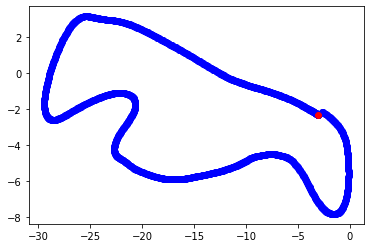

In [34]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])

plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')



In [36]:

def evaluate(model, envs):
    avg_r = []
    
    for env in envs:
        done = False
        obs = env.reset()

        r = 0
        while not done:
            action = model.compute_single_action(obs, explore=False)
            obs, reward, done, info = env.step(action)
            r += reward

        avg_r.append(r)
        
    return np.mean(avg_r)


eval_envs = [
    F110RaceEnv({}, test_map_name='phy1', laps=1),
    F110RaceEnv({}, test_map_name='phy2', laps=1),
    F110RaceEnv({}, test_map_name='phy3', laps=1),
    F110RaceEnv({}, test_map_name='phy4', laps=1),
    F110RaceEnv({}, test_map_name='phy5', laps=1),
    F110RaceEnv({}, test_map_name='phy6', laps=1),
]

evaluate(trainer, eval_envs)

lap: [12.32]
lap: [13.46]
lap: [13.05]
lap: [13.1]
lap: [13.84]
lap: [13.39]


13.908333333333317

## Exporting models

In [9]:
import torch

policy_model = trainer.get_policy().model
policy_model_hiddens = policy_model._hidden_layers
policy_model_logits = policy_model._logits
policy_model_hiddens

Sequential(
  (0): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=142, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (1): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Tanh()
    )
  )
)

In [10]:
import torch
policy_path = '../checkpoints/race_v2.0.4.pt'
torch.save({
    'h1': policy_model_hiddens[0]._model.state_dict(),
    'h2': policy_model_hiddens[1]._model.state_dict(),
    'logits': policy_model_logits._model.state_dict()
}, policy_path)

In [ ]:
class Policy(torch.nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.h1 = torch.nn.Sequential(
                torch.nn.Linear(in_features=182, out_features=300, bias=True),
                torch.nn.Tanh()
            )
        self.h2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=300, bias=True),
            torch.nn.Tanh()
        )
        
        self.logits =  torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=4, bias=True),
        )
        
    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.logits(x)

exported_policy = Policy()
exported_policy.h1.load_state_dict(torch.load(policy_path)['h1'])
exported_policy.h2.load_state_dict(torch.load(policy_path)['h2'])
exported_policy.logits.load_state_dict(torch.load(policy_path)['logits'])
exported_policy.eval()

In [ ]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben1')
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    obs_t = torch.tensor(obs, dtype=torch.float32)
    output = exported_policy(obs_t).detach().numpy()
    v = output[0]
    th = output[1]
#     v = np.clip(v, -1, 1)
#     th = np.clip(th, -1, 1)
    obs, reward, done, info = env.step([v, th])
#     print(obs[-2:])
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    env.render()
print(f'reward:{r}')
env.close()

# hist

## Reward plots

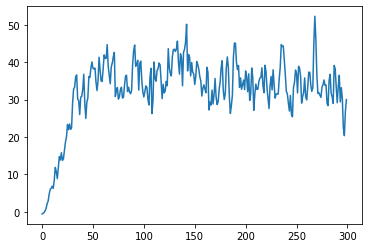

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

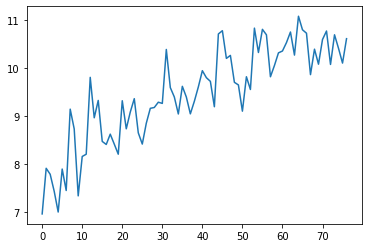

In [5]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/phy_v6.1.0_r', 'rb') as f:
    rs = pickle.load(f)
    
    
plt.plot(rs)

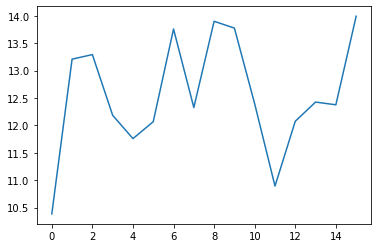

In [6]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/phy_v6.1.0_er', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
